In [1]:
import os, argparse, shutil
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from IPython.display import display
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
import subprocess
from itertools import groupby, count
from collections import deque
from io import StringIO
import ctypes as ct
import re
from pandarallel import pandarallel

In [2]:
# translate for building complement of a DNA sequence
compl = str.maketrans('ATGCNatgcn', 'TACGNatgcn')

In [3]:
class ArgHelpFormatter(argparse.HelpFormatter):
    '''
    Formatter adding default values to help texts.
    '''
    def __init__(self, prog):
        super().__init__(prog)

    ## https://stackoverflow.com/questions/3853722
    #def _split_lines(self, text, width):
    #   if text.startswith('R|'):
    #       return text[2:].splitlines()  
    #   # this is the RawTextHelpFormatter._split_lines
    #   return argparse.HelpFormatter._split_lines(self, text, width)

    def _get_help_string(self, action):
        text = action.help
        if  action.default is not None and \
            action.default != argparse.SUPPRESS and \
            'default:' not in text.lower():
            text += ' (default: {})'.format(action.default)
        return text

In [4]:
def get_args(args=None):
    parser = argparse.ArgumentParser(description='Estimates read starts (transposase insertion sites) for ONT rapid libraries',
                                     formatter_class=ArgHelpFormatter, 
                                     add_help=False)

    main_group = parser.add_argument_group('Main Options')
    main_group.add_argument('reads',
                            nargs='+',
                            help='fastq files or path to directories containing fastq files (recursion depth 1)')
    main_group.add_argument('genome',
                            help='Fasta file containing the genomic sequences that is searched for insertion sites.')
    main_group.add_argument('adapter',
                            help='Transposon Y adapter sequence')
    main_group.add_argument('--prefix',
                            help="filename for readstarts in tap seperated value (.tsv) format",
                            default="readstarts")
    #main_group.add_argument('--verbose_out_file',
    #                        help="print detailed, human readable information about each read to this file")
    #main_group.add_argument('--verbose_col_width',
    #                        help="column width for verbose output",
    #                        type=int,
    #                        default=250)
    main_group.add_argument('--plot',
                            help='plot results of gaussian approximation',
                            action='store_true')
    main_group.add_argument('--circular',
                            action="store_true")
    main_group.add_argument('--strip',
                            help="number of bases stripped from alignments to cope with coincidently identical sequences",
                            type=int,
                            default=5)
    main_group.add_argument('--wordsize',
                            help='',
                            type=int,
                            default=8)
    main_group.add_argument('--max_dist',
                            help='''max distance between an adapter and a genome alignment to perform pairwise-alignment 
                                 in order to identify the exact transition point''',
                            type=int,
                            default=200)
    main_group.add_argument('--min_readlength',
                            help="min length of reads to be analyzed",
                            type=int,
                            default=500)
    main_group.add_argument('--processes',
                            type=int,
                            default=6)
    main_group.add_argument('--batchsize',
                            type=int,
                            default=8000)
    
    align_group = parser.add_argument_group('Alignment Options')
    align_group.add_argument('--match',
                             help='match score',
                             type=int,
                             default=1)
    align_group.add_argument('--mismatch',
                             help='mismatch penalty',
                             type=int,
                             default=-2)
    align_group.add_argument('--gap_open',
                             help='gap open penalty',
                             type=int,
                             default=-4)
    align_group.add_argument('--gap_extension',
                             help='gap extension penalty',
                             type=int,
                             default=-1)

    filter_group = parser.add_argument_group('Filter Options')
    filter_group.add_argument('--mean',
                              help='mean of per-base difference of actual sequence length from read length',
                              type=float)
    filter_group.add_argument('--std',
                              help='standard deviation of per-base difference of actual sequence length from read length',
                              type=float)
    filter_group.add_argument('--min_blen',
                              help="min produced alignment length (including errors)",
                              type=int,
                              default=20)
    filter_group.add_argument('--min_adapter_blen',
                              help="min produced alignment length (including errors)",
                              type=int,
                              default=50)
    filter_group.add_argument('--min_genome_blen',
                              help="min produced alignment length (including errors)",
                              type=int,
                              default=50)
    filter_group.add_argument('--f_window',
                              help="sequence window around the position of transition from "+\
                                   "the adapter sequence to the chromosome sequence",
                              type=int,
                              default=7)
    filter_group.add_argument('--f_max_w_err',
                              help="max amount of errors (insertions, deletions, mismatches) "+\
                                   "within the specified sequence window",
                              type=int,
                              default=3)
    filter_group.add_argument('--f_max_mm_strech',
                              help="max amount of deletions or insertions in the whole realignment",
                              type=int,
                              default=3)

    help_group = parser.add_argument_group('Help')
    help_group.add_argument('-h', '--help', 
                            action='help', 
                            default=argparse.SUPPRESS,
                            help='Show this help message and exit.')
    if args:
        return parser.parse_args(args)
    return parser.parse_args()

In [5]:
def run_minimap2(ref_fn, fq_fn, paf_fn):
    cmd ='minimap2 -x map-ont -c --eqx --secondary=no -t 4 {} {} >{} 2> /dev/null'.format(ref_fn, fq_fn, paf_fn)
    #print('Running:', cmd)
    return os.system(cmd)

In [6]:
def parse_paf(fn, cigar=False):
    usecols = list(range(12))
    names = ["qid", "qlen", "qst", "qen", "strand", "subj", 
             "slen", "sst", "sen", "mlen", "blen", "mapq"]
    dtype = {"qid": str, "qlen": np.int32, "qst": np.int32, 
             "qen": np.int32, "strand": str, "subj": str,
             "slen": np.int32, "sst": np.int32, "sen": np.int32, 
             "mlen": np.int32, "blen": np.int32, "mapq": np.int32}
    converters = {}
    if cigar:
        usecols.append(22)
        names.append('cg')
        converters['cg'] = lambda x: x.split(':')[-1]
    return pd.read_csv(fn, sep='\t', header=None,
                       usecols=usecols,
                       names=names,
                       dtype=dtype,
                       converters=converters)

In [7]:
def fix_query_st(row):
    trimmed_query = 0
    trimmed_subject = 0
    if row.trans_order == 1.:
        cg = row.cg_ad
        qen = row.qen_ad
    else:
        cg = row.cg_gn
        qen = row.qen_gn
    cg_list = re.findall(cg_pat, cg)
    for bases,op in reversed(cg_list):
        bases = int(bases)
        if op == "=" and bases >= args.wordsize:
            return qen - trimmed_query, trimmed_subject
            break
        if op == "=" or op == 'X':
            trimmed_query += bases
            trimmed_subject += bases
        elif op == 'I':
            trimmed_query += bases
        else: # == D
            trimmed_subject += bases
    # unsuccessful
    return np.nan, np.nan

In [8]:
def fix_query_en(row):
    trimmed_query = 0
    trimmed_subject = 0
    if row.trans_order == 1.:
        cg = row.cg_gn
        qst = row.qst_gn
    else:
        cg = row.cg_ad
        qst = row.qst_ad
    for m in re.finditer(cg_pat, cg):
        bases, op = int(m.group(1)), m.group(2)
        if op == "=" and bases >= args.wordsize:
            return qst + trimmed_query, trimmed_subject
            break
        if op == "=" or op == 'X':
            trimmed_query += bases
            trimmed_subject += bases
        elif op == 'I':
            trimmed_query += bases
        else: # == D
            trimmed_subject += bases
    # unsuccessful
    return np.nan, np.nan

In [9]:
def get_query_seq(df, sel, fix=True):
    df['ref1_trim'], df['ref2_trim'] = 0, 0
    
    cg_ad = df.cg_ad.str.replace('D|I', 'X')
    cg_gn = df.cg_gn.str.replace('D|I', 'X')
    
    sel_ = sel & (df.trans_order == 1.) & (cg_ad.str.rstrip('=').str.rsplit('X', n=1).str[-1].astype(np.float32) >= args.wordsize) # & (df.strand_ad == '+')
    df.loc[sel_ , 'query_st'] = df[sel_].qen_ad
    sel_ = sel & (df.trans_order == 1.) & (cg_gn.str.split('=', n=1).str[0].astype(np.float32) >= args.wordsize) # & (df.strand_ad == '+')
    df.loc[sel_ , 'query_en'] = df[sel_].qst_gn
    
    sel_ = sel & (df.trans_order == -1.) & (cg_gn.str.rstrip('=').str.rsplit('X', n=1).str[-1].astype(np.float32) >= args.wordsize) # & (df.strand_ad == '+') 
    df.loc[sel_ , 'query_st'] = df[sel_].qen_gn
    sel_ = sel & (df.trans_order == -1.) & (cg_ad.str.split('=', n=1).str[0].astype(np.float32) >= args.wordsize) # & (df.strand_ad == '+')
    df.loc[sel_ , 'query_en'] = df[sel_].qst_ad
    
    if fix:
        # fix query end & start of reads with insufficient terminal alignments
        df.loc[sel & df.query_st.isnull(), ['query_st', 'ref1_trim']] = pd.DataFrame(
            df.loc[sel & df.query_st.isnull()].apply(lambda row: fix_query_st(row), axis=1).values.tolist(), 
            index=df.loc[sel & df.query_st.isnull()].index, columns=['query_st', 'ref1_trim']
        )
        df.loc[sel & df.query_en.isnull(), ['query_en', 'ref2_trim']] = pd.DataFrame(
            df.loc[sel & df.query_en.isnull()].apply(lambda row: fix_query_en(row), axis=1).values.tolist(), 
            index=df.loc[sel & df.query_en.isnull()].index, columns=['query_en', 'ref2_trim']
        )
    
    df.loc[sel, 'query_st'] -= args.strip
    df.loc[sel, 'query_en'] += args.strip
    df.loc[sel, 'ref1_trim'] += args.strip
    df.loc[sel, 'ref2_trim'] += args.strip
    return df

In [10]:
def sequence_length_stats(df):
    dfs = []
    # add length of read seq that aligns as "qalen"
    dfs.append((df[df.subj.notnull()].qen - df[df.subj.notnull()].qst).to_frame(name='qalen'))
    # add length of genome seq that aligns as "salen"
    dfs.append((df[df.subj.notnull()].sen - df[df.subj.notnull()].sst).abs().to_frame(name='salen'))
    ## add match, mismatch, insertion and deletion counts
    #two_groups = '(?P<digit>[0-9]*)(?P<letter>[=XID])'
    #d = df[df.subj_gn.notnull()].cg_gn.str.extractall(two_groups)
    #d.loc[:, 'digit'] = d.digit.astype("float32")
    #for letter in ['=', 'X', 'I', 'D']:
    #    dfs.append(d.loc[d.letter == letter].groupby(level=0).agg('sum').rename(columns = {'digit':letter}))
    stats = pd.concat(dfs, axis=1).fillna(0.)
    data = (stats.salen - stats.qalen)/stats.qalen
    args.mean, args.std = norm.fit(data)
    if args.plot:
        fig, ax = plt.subplots(figsize=(8,6))
        ax.hist(data, bins=100, density=True)
        xmin, xmax = ax.get_xlim()
        x = np.linspace(xmin, xmax, 200)
        y = norm.pdf(x, args.mean, args.std)
        ax.plot(x, y)
        plt.show()

In [11]:
def count_iter_items(iterable):
        counter = count()
        deque(zip(iterable, counter), maxlen=0)  # (consume at C speed)
        return next(counter)

In [12]:
def cigar_str(query, subj):
    cs = []
    for q,s in zip(query, subj):
        if q == s:
            cs.append('=')
        elif q == '-':
            cs.append('D')
        elif s == '-':
            cs.append('I')
        else:
            cs.append('X')
    return "".join(cs)
    #return "".join(["{}{}".format(count_iter_items(g), k) for k,g in groupby(cs)])

In [13]:
def backtrace_css_gapped(ops, s1len, cs=[]):
    traces = []
    if sum(ops.shape[1:]) == 2:
        #return ["".join(["{}{}".format(count_iter_items(g), k) for k,g in groupby(cs)])]
        return ["".join(cs)]
    if ops[0,-1,-1]: # insertion
        traces += ( backtrace_css_gapped(ops[:,:,:-1], s1len, ['I'] + cs) )
    if ops[1,-1,-1]: # deletion
        traces += ( backtrace_css_gapped(ops[:,:-1,:], s1len, ['D'] + cs) )
    if ops[2,-1,-1]: # match
        traces += ( backtrace_css_gapped(ops[:,:-1,:-1], s1len, ['='] + cs) )
    if ops[3,-1,-1]: # mismatch
        traces += ( backtrace_css_gapped(ops[:,:-1,:-1], s1len, ['X'] + cs) )
    if ops[4,-1,-1]: # free gap
        if ops.shape[1] > s1len + 1:
            jump_to = s1len + 1
            char = '>'
        else:
            jump_to = ops[5,:,-1].argmax() + 1
            char = '<'
        stepsize = ops.shape[1] - jump_to
        traces += ( backtrace_css_gapped(ops[:,:jump_to,:], s1len, [char]*stepsize + cs) )
    return traces

In [14]:
def gapped_twinalign(query, subj1, subj2, m=1, mm=-2, go=-4, ge=-1):
    qlen, s1len, s2len = len(query), len(subj1), len(subj2)
    subj = subj1 + subj2
    min_val = np.iinfo(np.int32).min
    # stores operations (insertion, deletion, match, mismatch, endgap_start, endgap_end) that maximize the score
    ops = np.zeros(shape=(6, s1len+s2len+1, qlen+1), dtype=np.bool_)
    ops[2,0,0] = True
    ops[0,0,1:] = True
    ops[1,1:s1len,0] = True
    ops[4,s1len:,0] = True
    ops[5,0,0] = True
    ops[5,s1len,0] = True
    # stores the best partial alignment scores
    scores = np.empty(shape=(s1len+s2len+1, qlen+1), dtype=np.int32)
    scores[0,0] = 0
    scores[0,1:] = np.arange(go + ge, go + (qlen+1)*ge, ge)
    scores[1:s1len+1,0] = np.arange(go + ge, go + (s1len+1)*ge, ge)
    
    op_scores = np.empty(shape=(5,), dtype=np.int32)
    for i in range(1,s1len):
        for j in range(1,qlen+1):
            # insertion
            op_scores[0] = scores[i,j-1] + (not ops[0,i,j-1]) * go + ge
            # deletion
            op_scores[1] = scores[i-1,j] + (not ops[1,i-1,j]) * go + ge
            # match/mismatch
            if (subj[i-1] == query[j-1]):
                op_scores[2] = scores[i-1,j-1] + m
                op_scores[3] = min_val
            else:
                op_scores[2] = min_val
                op_scores[3] = scores[i-1,j-1] + mm
            
            scores[i,j] = op_scores[:4].max()
            ops[:4,i,j] = op_scores[:4] == scores[i,j]
    for i in range(s1len,s1len+1):
        for j in range(1,qlen+1):
            # insertion
            op_scores[0] = scores[i,j-1] + (not ops[0,i,j-1]) * go + ge
            # deletion
            op_scores[1] = scores[i-1,j] + (not ops[1,i-1,j]) * go + ge
            # match/mismatch
            if (subj[i-1] == query[j-1]):
                op_scores[2] = scores[i-1,j-1] + m
                op_scores[3] = min_val
            else:
                op_scores[2] = min_val
                op_scores[3] = scores[i-1,j-1] + mm
            # free end gap
            max_in_col = scores[:i,j].argmax()
            op_scores[4] = scores[max_in_col,j]
            
            scores[i,j] = op_scores.max()
            ops[:4,i,j] = op_scores[:4] == scores[i,j]
            if op_scores[4] == scores[i,j]:
                ops[4,i,j] = True # gap start
                ops[5,max_in_col,j] = True # gap end
            #else:
            #    ops[5,i,j] = True # gap end
            ops[5,i,j] = True # gap end
    scores[s1len:,0] = 0
    for i in range(s1len+1,s1len+s2len+1):
        for j in range(1,qlen+1):
            # insertion
            op_scores[0] = scores[i,j-1] + (not ops[0,i,j-1]) * go + ge
            # deletion
            op_scores[1] = scores[i-1,j] + (not ops[1,i-1,j]) * go + ge
            # match/mismatch
            if (subj[i-1] == query[j-1]):
                op_scores[2] = scores[i-1,j-1] + m
                op_scores[3] = min_val
            else:
                op_scores[2] = min_val
                op_scores[3] = scores[i-1,j-1] + mm
            # free start gap
            op_scores[4] = scores[s1len,j]
            
            scores[i,j] = op_scores.max()
            ops[:5,i,j] = op_scores == scores[i,j]
            if ops[4,i,j]:
                ops[5,s1len,j] = True # gap end
    return scores, ops#np.packbits(ops, axis=0)

In [15]:
def align_row(row):
    scores,_ = gapped_twinalign(row.query_seq, row.ref1, row.ref2)
    #row['score'] = score
    return scores[-1,-1]

In [16]:
def c_align_row(row):
    if pd.isnull(row.ref1):
        #row['score'] = np.nan
        #row['transisions'] = None
        return row
    qlen, s1len, s2len = len(row.query_seq), len(row.ref1), len(row.ref2)
    query, subj = row.query_seq.encode("utf8"), (row.ref1+row.ref2).encode("utf8")
    align(query, subj, 
          qlen, s1len, s2len,
          args.match, args.mismatch, args.gap_open, args.gap_extension,
          scores_pp, *ops_pp)
    score = scores[s1len+s2len, qlen]
    #print(row.query_seq, row.ref1, row.ref2)
    #return scores[s1len+s2len, qlen]
    
    transitions = np.zeros(shape=(s1len+1, s2len+1), dtype=np.bool_)
    if transitions.flags['C_CONTIGUOUS'] == False:
        transitions = np.ascontiguousarray(transitions, dtype=transitions.dtype)
    transitions_pp = (transitions.ctypes.data + np.arange(transitions.shape[0]) * transitions.strides[0]).astype(np.uintp)
    backtrace(*ops_pp,
              qlen, s1len, s2len,
              s1len+s2len, qlen, 0, s2len, 
              transitions_pp)
    transitions_hr = list(zip(*np.where(transitions)))
    
    row['score'] = score
    row['transitions'] = transitions_hr
    return row

In [17]:
def test_align(query_seq, ref1, ref2):
    qlen, s1len, s2len = len(query_seq), len(ref1), len(ref2)
    query, subj = query_seq.encode("utf8"), (ref1+ref2).encode("utf8")
    align(query, subj, 
          qlen, s1len, s2len,
          args.match, args.mismatch, args.gap_open, args.gap_extension,
          scores_pp, *ops_pp)
    score = scores[s1len+s2len, qlen]
    
    transitions = np.zeros(shape=(s1len+1, s2len+1), dtype=np.bool_)
    if transitions.flags['C_CONTIGUOUS'] == False:
        transitions = np.ascontiguousarray(transitions, dtype=transitions.dtype)
    transitions_pp = (transitions.ctypes.data + np.arange(transitions.shape[0]) * transitions.strides[0]).astype(np.uintp)
    backtrace(*ops_pp,
              qlen, s1len, s2len,
              s1len+s2len, qlen, 0, s2len, 
              transitions_pp)
    transitions_hr = list(zip(*np.where(transitions)))

    print(score)
    print(scores[:s1len+s2len+1, :qlen+1])
    print(ops[:,:s1len+s2len+1, :qlen+1])
    print(transitions_hr)

In [18]:
cg_pat = re.compile("(\d+)([=XID])")

In [19]:
args = get_args(['/vol/seqpro2019/MLinder_SMART/Run00376/barcode16.fastq', '/vol/seqpro2019/MLinder_SMART/analysis/Run00376/MIT52.fa', '/vol/seqpro2019/MLinder_SMART/analysis/Run00376/pUC19_ISCg1.fa', '--prefix', 'barcode01', '--wordsize', '12', '--plot'])

In [20]:
fq_files = []
for entry in args.reads:
    if os.path.isfile(entry) and (entry.endswith(".fastq") or entry.endswith(".fq")):
        fq_files.append(entry)
    else:
        fq_files.extend([os.path.join(entry, f) for f in os.listdir(entry) if os.path.isfile(os.path.join(entry, f)) \
            and (f.endswith(".fastq") or f.endswith(".fq"))])

In [21]:
adapter = {}
print(" - reading adapter sequence ...")
for record in SeqIO.parse(args.adapter, "fasta"):
    adapter[str(record.id)] = str(record.seq)
adapter = pd.DataFrame.from_dict(adapter, orient='index', columns=['seq'], dtype='string')
print('{:>11} adapter sequence(s) in fasta file'.format(len(adapter)))

print(" - reading genome fasta ...")
genome = {}
for record in SeqIO.parse(args.genome, "fasta"):
    genome[str(record.id)] = str(record.seq)
genome = pd.DataFrame.from_dict(genome, orient='index', columns=['seq'], dtype='string')
print('{:>11} genomic sequence(s) in fasta file'.format(len(genome)))

print(" - reading fastq files ...")
reads = {}
#reads = pd.DataFrame([], {'seq':Seq})
for fqFile in fq_files:
    for record in SeqIO.parse(fqFile, "fastq"):
        reads[str(record.id)] = str(record.seq)
reads = pd.DataFrame.from_dict(reads, orient='index', columns=['seq'], dtype='string')
print("{:>11} reads in dataset\n".format(len(reads)))

 - reading adapter sequence ...
          1 adapter sequence(s) in fasta file
 - reading genome fasta ...
          1 genomic sequence(s) in fasta file
 - reading fastq files ...
     272410 reads in dataset



In [22]:
tmp_dir = '{}_tmp'.format(args.prefix)
if os.path.exists(tmp_dir):
    shutil.rmtree(tmp_dir)
os.makedirs(tmp_dir)

In [23]:
print(" - performing reads to adapter reference mapping ...")
fq_fn = " ".join(fq_files)
ref_fn = args.adapter
paf_fn = os.path.join(tmp_dir, "adapter_alignment.paf")
exit_code = run_minimap2(ref_fn, fq_fn, paf_fn)
if exit_code:
    print('ERROR: adapter reference mapping failed with exit code', exit_code)
    exit(1)
ad_algn_df = parse_paf(paf_fn, cigar=True)#.set_index('qid')
print("{:>11} {:>7} primary alignments against adapter sequence(s)".format(len(ad_algn_df), ""))
c = sum(ad_algn_df.strand == '+')
print("{:>11} {:>5.1f} % against (+) strand".format(c, c/len(ad_algn_df)*100.))
c = sum(ad_algn_df.strand == '-')
print("{:>11} {:>5.1f} % against (-) strand".format(c, c/len(ad_algn_df)*100.))
c = len(set(ad_algn_df.qid))
print("{:>11} {:>5.1f} % of reads align against any adapter sequence".format(c, c/len(reads)*100.))
#df = pd.merge(df, algn_df, how='outer', left_index=True, right_index=True, sort=False, suffixes=('_x', '_y'))

 - performing reads to adapter reference mapping ...
     175673         primary alignments against adapter sequence(s)
      58740  33.4 % against (+) strand
     116933  66.6 % against (-) strand
     164011  60.2 % of reads align against any adapter sequence


In [24]:
print(" - performing reads to genome reference mapping ...")
ref_fn = args.genome
paf_fn = os.path.join(tmp_dir, "genome_alignment.paf")
exit_code = run_minimap2(ref_fn, fq_fn, paf_fn)
if exit_code:
    print('ERROR: adapter reference mapping failed with exit code', exit_code)
    exit(1)
gn_algn_df = parse_paf(paf_fn, cigar=True)#.set_index('qid')
print("{:>11} {:>7} primary alignments against genomic sequence(s)".format(len(gn_algn_df), ""))
c = sum(gn_algn_df.strand == '+')
print("{:>11} {:>5.1f} % against (+) strand".format(c, c/len(gn_algn_df)*100.))
c = sum(gn_algn_df.strand == '-')
print("{:>11} {:>5.1f} % against (-) strand".format(c, c/len(gn_algn_df)*100.))
c = len(set(gn_algn_df.qid))
print("{:>11} {:>5.1f} % of reads align against any genome sequence".format(c, c/len(reads)*100.))
#df = pd.merge(df, algn_df, how='outer', left_index=True, right_index=True, sort=False, suffixes=('_ad', '_gn'))

 - performing reads to genome reference mapping ...
     143593         primary alignments against genomic sequence(s)
      95609  66.6 % against (+) strand
      47984  33.4 % against (-) strand
     133750  49.1 % of reads align against any genome sequence


 - determining statistics about per-base difference ([align. subject len] - [align. query len]) / [align. query len] al from genome alignments


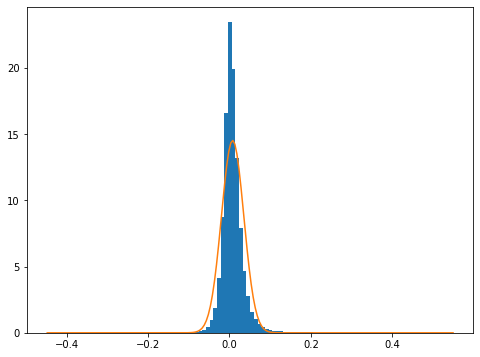

     0.0079 mean of per-base difference in sequence length
     0.0275 std dev of per-base difference in sequence length


In [25]:
if not (args.mean and args.std):
    print(" - determining statistics about per-base difference ([align. subject len] - [align. query len]) / [align. query len] al from genome alignments")
    sequence_length_stats(gn_algn_df)
    print("{:>11.4f} mean of per-base difference in sequence length".format(args.mean))
    print("{:>11.4f} std dev of per-base difference in sequence length".format(args.std))

In [26]:
print(" - joining alignment data and filtering for adjacent adapter-genome alignments")
# determine order of alignments of each read with respect to each adapter-subject pair
d = pd.concat([ad_algn_df, gn_algn_df], keys=['ad', 'gn'])
for ad_id in adapter.index:
    for gn_id in genome.index:
        comb = [ad_id, gn_id]
        o = d.loc[(d.subj.isin(comb))].sort_values(by=["qid", "qst"], ascending=True)
        d.loc[o.index, ":".join(comb)] = np.arange(len(o))

 - joining alignment data and filtering for adjacent adapter-genome alignments


In [27]:
d_ad = pd.merge(pd.DataFrame(reads.index, columns=['rid']).set_index('rid', drop=False), d.loc[d.index.droplevel(1) == 'ad'].set_index('qid', drop=False),
                how='outer', left_index=True, right_index=True, sort=False)
#d_gn = pd.merge(df, d.loc[d.index.droplevel(1) == 'gn'].set_index('qid', drop=False),
#                how='outer', left_index=True, right_index=True, sort=False)
df = pd.merge(d_ad, 
              d.loc[d.index.droplevel(1) == 'gn'].set_index('qid', drop=False), 
              how='outer', left_index=True, right_index=True, sort=False, suffixes=('_ad', '_gn'))
# reset index
df = df.reset_index(drop=True)
sel = df.subj_ad.notnull() & \
      df.subj_gn.notnull()

In [28]:
# determine if the adapter alignment and the genome alignment are adjacent to each other with respect to 
# all other alignments of the given read to the same adapter and genome sequence
for ad_id in adapter.index:
    for gn_id in genome.index:
        sel_ = (df.subj_ad == ad_id) & (df.subj_gn == gn_id)
        df.loc[sel_, 'align_dist'] = (df[sel_]["{}:{}_ad".format(ad_id, gn_id)] - df[sel_]["{}:{}_gn".format(ad_id, gn_id)]).abs()
print('{:>11} {:>7} entities after joining'.format(len(df), ""))
c = sum(np.logical_not(sel))
print('{:>11} {:>5.1f} % not aligning against both an adapter and a genomic seq'.format(c, c/len(df)*100.))
c = sum((df.align_dist > 1.))
print('{:>11} {:>5.1f} % are entries are alignments that are not adjacent to each other'.format(c, c/len(df)*100.))
sel &= (df.align_dist == 1.)
print()
c = len(set(df.loc[sel, 'rid']))
print('{:>11} {:>5.1f} % reads remaining that contain potential transitions between adapter and genomic seq.'.format(c, c/len(reads)*100.))
c = sum(sel)
print('{:>11} {:>5.1f} % potential transitions remaining'.format(c, c/len(df)*100.))

     295580         entities after joining
     246797  83.5 % not aligning against both an adapter and a genomic seq
       7149   2.4 % are entries are alignments that are not adjacent to each other

      37564  13.8 % reads remaining that contain potential transitions between adapter and genomic seq.
      41634  14.1 % potential transitions remaining


In [29]:
# deleting non-potential transitions at this point so that all procentual values are with respect to potential ones only
print(" - deleting all entries from dataframe that are not potential transitions")
df = df.drop(df.index[np.logical_not(sel)]).astype({"qlen_ad":np.int32, "qst_ad":np.int32, "qen_ad":np.int32, "slen_ad":np.int32,
                                                   "sst_ad":np.int32, "sen_ad":np.int32, "mlen_ad":np.int32, "blen_ad":np.int32, "mapq_ad":np.int32,
                                                   "qlen_gn":np.int32, "qst_gn":np.int32, "qen_gn":np.int32, "slen_gn":np.int32,
                                                   "sst_gn":np.int32, "sen_gn":np.int32, "mlen_gn":np.int32, "blen_gn":np.int32, "mapq_gn":np.int32})
sel = df.subj_ad.notnull() & \
      df.subj_gn.notnull() & \
      (df.align_dist == 1.)

 - deleting all entries from dataframe that are not potential transitions


In [30]:
# identify if row describes a transition from adapter to genomic sequence or vise versa
df.loc[sel,'trans_order'] = 0 # qst_ad == qst_gn
df.loc[sel & (df.qst_ad < df.qst_gn), 'trans_order'] = 1 # adapter -> genome
df.loc[sel & (df.qst_ad > df.qst_gn), 'trans_order'] = -1 # genome -> adapter
c = sum(df[sel].qst_ad < df[sel].qst_gn)
print('{:>11} {:>5.1f} % of total potential transpositions are adapter -> genome'.format(c, c/len(df[sel])*100.))
c = sum(df[sel].qst_ad > df[sel].qst_gn)
print('{:>11} {:>5.1f} % of total potential transpositions are genome -> adapter'.format(c, c/len(df[sel])*100.))

# select all entries with an sufficiently long alignment to both the adapter and the genome
print(' - filter potential subject transitions based on alignment lengths')
sel_ = (df.blen_ad >= args.min_adapter_blen) & \
       (df.blen_gn >= args.min_genome_blen)
c = sum(sel & np.logical_not(sel_))
print('{:>11} {:>5.1f} % of total potential transpositions filtered'.format(c, c/len(df)*100.))
c = sum(sel & np.logical_not(df.blen_ad >= args.min_adapter_blen))
print('{:>11} {:>5.1f} % bc adapter alignment length < {}'.format(c, c/len(df)*100., args.min_adapter_blen))
c = sum(sel & np.logical_not(df.blen_gn >= args.min_genome_blen))
print('{:>11} {:>5.1f} % bc genome alignment length < {}'.format(c, c/len(df)*100., args.min_genome_blen))
sel &= sel_
c = sum(sel)
print('{:>11} {:>5.1f} % potential transitions remaining'.format(c, c/len(df)*100.))

      24639  59.2 % of total potential transpositions are adapter -> genome
      16995  40.8 % of total potential transpositions are genome -> adapter
 - filter potential subject transitions based on alignment lengths
        231   0.6 % of total potential transpositions filtered
         50   0.1 % bc adapter alignment length < 50
        181   0.4 % bc genome alignment length < 50
      41403  99.4 % potential transitions remaining


In [31]:
# determine query seq start and end in read coordinates
print(" - determine query seq start and end in read coordinates")
df = get_query_seq(df, sel)
c = sum(sel & (df.query_st.isnull() | df.query_en.isnull()))
print('{:>11} {:>5.1f} % of remaining potential transpositions had < {} matching terminal bases'.format(c, c/sum(sel)*100., args.wordsize))
sel &= df.query_st.notnull() & df.query_en.notnull()
c = sum(sel)
print('{:>11} {:>5.1f} % potential transitions remaining'.format(c, c/len(df)*100.))

 - determine query seq start and end in read coordinates
          0   0.0 % of remaining potential transpositions had < 12 matching terminal bases
      41403  99.4 % potential transitions remaining


In [32]:
# filter out entries with query seq. that are too long -> distance between adapter and genome alignment is too large
print(" - exclude entries based on query sequence length (adapter-genome alignment distance) from analysis")
too_short = (df.query_en - df.query_st) < 0.
too_long = (df.query_en - df.query_st) > args.max_dist
c = sum(too_short)
print('{:>11} {:>5.1f} % of remaining potential transpositions removed due to query seq. length < 0 nt (alignment overlap of more than {} nt)'.format(c, c/sum(sel)*100., args.strip))
c = sum(too_long)
print('{:>11} {:>5.1f} % of remaining potential transpositions removed due to query seq. length > {} nt'.format(c, c/sum(sel)*100., args.max_dist))
sel &= np.logical_not(too_short) & np.logical_not(too_long)
c = sum(sel)
print('{:>11} {:>5.1f} % potential transitions remaining'.format(c, c/len(df)*100.))

 - exclude entries based on query sequence length (adapter-genome alignment distance) from analysis
        504   1.2 % of remaining potential transpositions removed due to query seq. length < 0 nt (alignment overlap of more than 5 nt)
        579   1.4 % of remaining potential transpositions removed due to query seq. length > 200 nt
      40320  96.8 % potential transitions remaining


In [33]:
# set query seq for each row
print(" - determining query sequences")
df.loc[sel, 'query_seq'] = df[sel].apply(lambda row: reads.loc[row.rid].seq[int(row.query_st) : int(row.query_en)], axis=1)

 - determining query sequences


In [34]:
# determine reference sequences
print(" - determining reference sequences")
#df.loc[sel, 'min_ref_len'] = ((df[sel].query_en - df[sel].query_st) * (1 + args.mean - 3 * args.std) - 0.5).round()
df.loc[sel, 'max_ref_len'] = ((df[sel].query_en - df[sel].query_st) * (1 + args.mean + 3 * args.std) + 0.5).round()

# set first and second reference seq
sel_ = sel & (df.trans_order == 1.) & (df.strand_ad == '+')
df.loc[sel_, 'ref1'] = df[sel_].apply(
    lambda row: adapter.loc[row.subj_ad].seq[(row.sen_ad - row.ref1_trim) : (row.sen_ad - row.ref1_trim) + int(row.max_ref_len)], axis=1)
sel_ = sel & (df.trans_order == 1.) & (df.strand_ad == '-')
df.loc[sel_, 'ref1'] = df[sel_].apply(
    lambda row: adapter.loc[row.subj_ad].seq[(row.sst_ad + row.ref1_trim) - int(row.max_ref_len) : (row.sst_ad + row.ref1_trim)], axis=1)
df.loc[sel_, 'ref1'] = df.loc[sel_, 'ref1'].str.translate(compl).str[::-1] # reverse complement


sel_ = sel & (df.trans_order == 1.) & (df.strand_gn == '+')
df.loc[sel_, 'ref2'] = df[sel_].apply(
    lambda row: genome.loc[row.subj_gn].seq[(row.sst_gn + row.ref2_trim) - int(row.max_ref_len) : (row.sst_gn + row.ref2_trim)], axis=1)
sel_ = sel & (df.trans_order == 1.) & (df.strand_gn == '-')
df.loc[sel_, 'ref2'] = df[sel_].apply(
    lambda row: genome.loc[row.subj_gn].seq[(row.sen_gn - row.ref2_trim) : (row.sen_gn - row.ref2_trim) + int(row.max_ref_len)], axis=1)
df.loc[sel_, 'ref2'] = df.loc[sel_, 'ref2'].str.translate(compl).str[::-1] # reverse complement


sel_ = sel & (df.trans_order == -1.) & (df.strand_gn == '+')
df.loc[sel_, 'ref1'] = df[sel_].apply(
    lambda row: genome.loc[row.subj_gn].seq[(row.sen_gn - row.ref1_trim) : (row.sen_gn - row.ref1_trim) + int(row.max_ref_len)], axis=1)
sel_ = sel & (df.trans_order == -1.) & (df.strand_gn == '-')
df.loc[sel_, 'ref1'] = df[sel_].apply(
    lambda row: genome.loc[row.subj_gn].seq[(row.sst_gn + row.ref1_trim) - int(row.max_ref_len) : (row.sst_gn + row.ref1_trim)], axis=1)
df.loc[sel_, 'ref1'] = df.loc[sel_, 'ref1'].str.translate(compl).str[::-1] # reverse complement


sel_ = sel & (df.trans_order == -1.) & (df.strand_ad == '+')
df.loc[sel_, 'ref2'] = df[sel_].apply(
    lambda row: adapter.loc[row.subj_ad].seq[(row.sst_ad + row.ref2_trim) - int(row.max_ref_len) : (row.sst_ad + row.ref2_trim)], axis=1)
sel_ = sel & (df.trans_order == -1.) & (df.strand_ad == '-')
df.loc[sel_, 'ref2'] = df[sel_].apply(
    lambda row: adapter.loc[row.subj_ad].seq[(row.sen_ad - row.ref2_trim) : (row.sen_ad - row.ref2_trim) + int(row.max_ref_len)], axis=1)
df.loc[sel_, 'ref2'] = df.loc[sel_, 'ref2'].str.translate(compl).str[::-1] # reverse complement

 - determining reference sequences


In [39]:
print(' - aligning')
# initialize the necessary data structures
wd = !pwd
print(os.path.join(str(wd[0]), "align.so"))
clib = os.path.join(str(wd[0]), "align.so")

nd_pp = np.ctypeslib.ndpointer(dtype=np.uintp, ndim=1, flags='C_CONTIGUOUS')
align = ct.CDLL(clib).align
align.argtypes = [ct.c_char_p, ct.c_char_p, 
                  ct.c_short, ct.c_short, ct.c_short,
                  ct.c_short, ct.c_short, ct.c_short, ct.c_short,
                  nd_pp, nd_pp, nd_pp, nd_pp, nd_pp, nd_pp, nd_pp]
align.restype = ct.c_int

backtrace = ct.CDLL(clib).backtrace
backtrace.argtypes = [nd_pp, nd_pp, nd_pp, nd_pp, nd_pp, nd_pp,
                      ct.c_short, ct.c_short, ct.c_short,
                      ct.c_short, ct.c_short, ct.c_short, ct.c_short,
                      nd_pp]
backtrace.restype = ct.c_int

ct.CDLL(clib).init()

max_subj_len = 2*int((args.max_dist * (1 + args.mean + 3 * args.std) + 0.5).round())
print(max_subj_len)
scores = np.empty(shape=(max_subj_len+1, args.max_dist+1), dtype=np.int16)
ops = np.empty(shape=(6,max_subj_len+1, args.max_dist+1), dtype=np.bool_)
#m, mm, go, ge = 1, -2, -4, -1
# initialize the fields that never change
scores[0,0] = 0
scores[0,1:] = np.arange(args.gap_open + args.gap_extension, args.gap_open + (args.max_dist+1)*args.gap_extension, args.gap_extension)
ops[:,0,:] = False
ops[:,:,0] = False
ops[0,0,1:] = True
ops[2,0,0] = True
ops[5,0,0] = True
if scores.flags['C_CONTIGUOUS'] == False:
    scores = np.ascontiguousarray(scores, dtype=scores.dtype)
if ops.flags['C_CONTIGUOUS'] == False:
    ops = np.ascontiguousarray(ops, dtype=ops.dtype)
scores_pp = (scores.ctypes.data + np.arange(scores.shape[0]) * scores.strides[0]).astype(np.uintp)
ops_pp = [(ops[i].ctypes.data + np.arange(ops[i].shape[0]) * ops[i].strides[0]).astype(np.uintp) for i in range(6)]

 - aligning
/vol/coryne/mhaak/crossalign/align.so
438


In [36]:
pandarallel.initialize(nb_workers=1, progress_bar=True)

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
for i,row in df[:500].iterrows():
    print(i)
    c_align_row(row)

7
8
14
15
25
26
28
42
44
48
55
62
68
69
82
86
93
98
102
125
126
132
133
143
145
152
166
167
173
179
185
187
190
206
215
222
227
237
240
244
252
263
264
279
282
299
301
302
303
304
308
313
315
354


In [38]:
print(df.loc[354].query_seq, df.loc[354].ref1, df.loc[354].ref2)

GAGCCAGTTAACTGGATCAGCTGTCCCCGTCTGAAACCATTCCCACTCAAGATTAACAATATGTACGCCCTTCTTCGCTTCGGCGGGTAGCTCATCCAACCATTGCGCCGTCTTTTTGTCGACTACCATGCCCACCAACGAGATCGGAAGAGCACACGTCTGCGTGC GAGCCGCAAAATACTGCTCAGACGCGTTAGAGTGCATTGATCTTATGGACCAACTGCCCTGAATGGATAAGGCACCGCAGAATGTAGTGGTTCAAATTACGGAAACCTAGAGCAATCCCACGCAAATGCTCCAACCGTCCGTTGATCGCTTCGACCGGACCGTTGGAGACACCAACATCGAAA GCGGCCAGTCGATCATGTTGAGGTTGACGTTGGCGTAATGCGCGTCGGGGGACCAATGATCGTTGACGAGGTAGGTGTACAGCGTGCCGTCCTCGAGCGCCTGGAAGCCGTTTGCCACACCACGCGGGACGTAAACTCCCACGTCAGGGGTAATTTTTTGCGTTACGACGTTACCGTACGTGC


In [ ]:
c_align_row(df.loc[354])

In [ ]:
# start the alignment
df[20:500].apply(lambda row: c_align_row(row), axis=1)
#df.loc[sel & (df.query_seq.str.len() > 0), 'norm_score'] = df[sel].score / df[sel].query_seq.str.len()
#df.loc[sel & (df.query_seq.str.len() == 0), 'norm_score'] = args.match # if the two alignments are fitting together perfetly

In [ ]:
df.loc[sel & (df.query_seq.str.len() == 0), ["query_seq", "ref1", "ref2", "score", "norm_score", "transitions"]]

In [ ]:
def plot_norm_score_distribution(df, nbins=50):
    x, y = df.query_seq.str.len(), df.norm_score
    
    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.005

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]

    # start with a rectangular Figure
    plt.figure(figsize=(8, 8))

    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False)

    ax_scatter.scatter(x, y, s=1., alpha=0.05)

    ax_histx.hist(x, bins=nbins)
    ax_histy.hist(y, bins=nbins, orientation='horizontal')

    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())
    
    plt.show()

In [ ]:
if args.plot:
    plot_norm_score_distribution(df[sel])

In [ ]:
d = df.loc[sel & (df.norm_score >= 0.5), ['trans_order','strand_ad','subj_ad','sst_ad', 'sen_ad', 'subj_gn','sst_gn', 'sen_gn','strand_gn','max_ref_len','norm_score','transitions']].explode('transitions')
d

In [ ]:
# set first and second reference seq
sel_ = (d.trans_order == 1.) & (d.strand_ad == '+')
d.loc[sel_, 'ts'] = d[sel_].apply(
    lambda row: (row.sen_ad - args.strip) + row.transitions[0], axis=1)
    #lambda row: adapter.loc[row.subj_ad].seq[(row.sen_ad - args.strip) : (row.sen_ad - args.strip) + int(row.max_ref_len)], axis=1)
sel_ = (d.trans_order == 1.) & (d.strand_ad == '-')
d.loc[sel_, 'ts'] = d[sel_].apply(
    lambda row: (row.sst_ad + args.strip) - row.transitions[0], axis=1)
    #lambda row: adapter.loc[row.subj_ad].seq[(row.sst_ad + args.strip) - int(row.max_ref_len) : (row.sst_ad + args.strip)], axis=1)

sel_ = (d.trans_order == 1.) & (d.strand_gn == '+')
d.loc[sel_, 'te'] = d[sel_].apply(
    lambda row: (row.sst_gn + args.strip) - int(row.max_ref_len) + row.transitions[1], axis=1)
    #lambda row: genome.loc[row.subj_gn].seq[(row.sst_gn + args.strip) - int(row.max_ref_len) : (row.sst_gn + args.strip)], axis=1)
sel_ = (d.trans_order == 1.) & (d.strand_gn == '-')
d.loc[sel_, 'te'] = d[sel_].apply(
    lambda row: (row.sen_gn - args.strip) + int(row.max_ref_len) - row.transitions[1], axis=1)
    #lambda row: genome.loc[row.subj_gn].seq[(row.sen_gn - args.strip) : (row.sen_gn - args.strip) + int(row.max_ref_len)], axis=1)

sel_ = (d.trans_order == -1.) & (d.strand_gn == '+')
d.loc[sel_, 'ts'] = d[sel_].apply(
    lambda row: (row.sen_gn - args.strip) + row.transitions[0], axis=1)
    #lambda row: genome.loc[row.subj_gn].seq[(row.sen_gn - args.strip) : (row.sen_gn - args.strip) + int(row.max_ref_len)], axis=1)
sel_ = (d.trans_order == -1.) & (d.strand_gn == '-')
d.loc[sel_, 'ts'] = d[sel_].apply(
    lambda row: (row.sst_gn + args.strip) - row.transitions[0], axis=1)
    #lambda row: genome.loc[row.subj_gn].seq[(row.sst_gn + args.strip) - int(row.max_ref_len) : (row.sst_gn + args.strip)], axis=1)

sel_ = (d.trans_order == -1.) & (d.strand_ad == '+')
d.loc[sel_, 'te'] = d[sel_].apply(
    lambda row: (row.sst_ad + args.strip) - int(row.max_ref_len) + row.transitions[1], axis=1)
    #lambda row: adapter.loc[row.subj_ad].seq[(row.sst_ad + args.strip) - int(row.max_ref_len) : (row.sst_ad + args.strip)], axis=1)
sel_ = (df.trans_order == -1.) & (df.strand_ad == '-')
d.loc[sel_, 'te'] = d[sel_].apply(
    lambda row: (row.sen_ad - args.strip) + int(row.max_ref_len) - row.transitions[1], axis=1)
    #lambda row: adapter.loc[row.subj_ad].seq[(row.sen_ad - args.strip) : (row.sen_ad - args.strip) + int(row.max_ref_len)], axis=1)

In [ ]:
d